### Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Read dataset

In [2]:
train = pd.read_csv('train.csv', index_col=0)
train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print(train.shape)
train.isna().sum()/train.shape[0] *100

(7613, 4)


keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

There are two columns having missing values, that is `keyword`: 0.8 percent and `location`: 33.3 percent. Two other attribute `text` and `target` are important.
- text is the desciption of tweeter comment
- target is class of Disaster Tweets: 1 is Disaster and 0 is not.

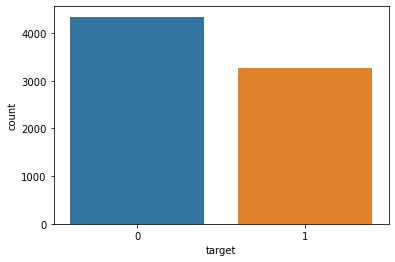

In [4]:
sns.countplot(data = train, x = 'target')
plt.show()

`keyword` and `location` are missing attribute. So, we can drop they.

In [5]:
train.drop(['keyword','location'], axis = 1, inplace=True)
train.head()

,text,target
id,,
1,Our Deeds are the Reason of this #earthquake M...,1
4,Forest fire near La Ronge Sask. Canada,1
5,All residents asked to 'shelter in place' are ...,1
6,"13,000 people receive #wildfires evacuation or...",1
7,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
import re
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove url from a text in tweet.

In [7]:
train['text'] = train['text'].apply(remove_URL)
train.head()

,text,target
id,,
1,Our Deeds are the Reason of this #earthquake M...,1
4,Forest fire near La Ronge Sask. Canada,1
5,All residents asked to 'shelter in place' are ...,1
6,"13,000 people receive #wildfires evacuation or...",1
7,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
X = train['text'].values
y = train['target'].values

### Preprocessing text before using machine learning to perdict result

I use sklearn library for this classification problem.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer

In [10]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer.fit(X)
tfidf_df = tfidf_vectorizer.transform(X)
tfidf_df.shape

(7613, 16760)

In [11]:
tfidf_df.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Chossing model

In [18]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,\
                             BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, check_scoring, f1_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split

In [13]:
def evaluate(model, name_model, X,y):
    scores = cross_val_score(model, X,y, cv=KFold(n_splits=5, shuffle=True), scoring= 'f1')
    print('Model: {}\n'.format(name_model))
    print('Mean f1-score : {}\n\n'.format(scores.mean()))

In [14]:
models = {
    'RandomForestClassifier' : RandomForestClassifier(n_estimators=100),
    'GradientBoostingClassifier' : GradientBoostingClassifier(n_estimators=100),
    'BaggingClassifier' : BaggingClassifier(n_estimators = 100),
    'ExtraTreesClassifier' : ExtraTreesClassifier(n_estimators = 100),
    'XGBClassifier' : XGBClassifier(n_estimators = 100, learning_rate = 0.01,
                                    eval_metric ='logloss',use_label_encoder =False),
    'SVC' : SVC()
}
for name, model in models.items():
    evaluate(model, name, tfidf_df, y)

Model: RandomForestClassifier

Mean f1-score : 0.7167202001298614


Model: GradientBoostingClassifier

Mean f1-score : 0.5917416955017313


Model: BaggingClassifier

Mean f1-score : 0.7268779415966427


Model: ExtraTreesClassifier

Mean f1-score : 0.7365821757799111


Model: XGBClassifier

Mean f1-score : 0.36973086880454087


Model: SVC

Mean f1-score : 0.7247161635333201




### Grid Search with SVC

In [15]:
param_grid = {
    'C':[0.01, 0.1, 1, 10]
}

Search = GridSearchCV(SVC(), param_grid, scoring = 'f1', cv = KFold(n_splits = 10, shuffle=True), verbose = 0)

Search.fit(tfidf_df, y)
print(Search.best_score_)

print(Search.best_params_)

0.7344978494463794
{'C': 10}


### hyperparameters grid search using optuna library

In [21]:
!pip install optuna

  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11107 sha256=91fd7acc090e31fa7d499c42cb50ca2ecd004132b1abda283d476661cd0bfe0a
  Stored in directory: c:\users\truong dang\appdata\local\pip\cache\wheels\7f\1a\65\84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.0
    Uninstalling importlib-metadata-3.10.0:
      Successfully uninstalled importlib-metadata-3.10.0


In [22]:
import optuna

In [40]:
def objective(trial):
    X_train, X_valid, y_train, y_valid =  train_test_split(tfidf_df, y, test_size= 0.2, shuffle= True, random_state= 42)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 9)
    }
    model = ExtraTreesClassifier(**params)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_valid)
    f1 = f1_score(y_valid, y_preds)
    
    return f1

In [42]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 20)

[I 2022-08-28 19:51:00,946] A new study created in memory with name: no-name-1e2dddf3-4174-40ec-8710-65a0279c0bb3
[I 2022-08-28 19:53:14,319] Trial 0 finished with value: 0.7242524916943522 and parameters: {'n_estimators': 400, 'min_samples_split': 7}. Best is trial 0 with value: 0.7242524916943522.
[I 2022-08-28 19:58:49,303] Trial 1 finished with value: 0.7305785123966942 and parameters: {'n_estimators': 1000, 'min_samples_split': 8}. Best is trial 1 with value: 0.7305785123966942.
[I 2022-08-28 20:01:18,373] Trial 2 finished with value: 0.7197986577181209 and parameters: {'n_estimators': 300, 'min_samples_split': 2}. Best is trial 1 with value: 0.7305785123966942.
[I 2022-08-28 20:07:15,245] Trial 3 finished with value: 0.7210657785179019 and parameters: {'n_estimators': 900, 'min_samples_split': 5}. Best is trial 1 with value: 0.7305785123966942.
[I 2022-08-28 20:10:56,715] Trial 4 finished with value: 0.7167919799498748 and parameters: {'n_estimators': 600, 'min_samples_split': 4}

In [43]:
study.best_params

{'n_estimators': 1000, 'min_samples_split': 8}

In [44]:
model = ExtraTreesClassifier(**study.best_params)

In [53]:
model.fit(tfidf_df, y)

ExtraTreesClassifier(min_samples_split=8, n_estimators=1000)

## Predict test dataset

In [47]:
test = pd.read_csv('test.csv')
X_test = test['text'].apply(remove_URL).values

In [50]:
# tranform test with tfidf_vectorizer 
X_test = tfidf_vectorizer.transform(X_test)
X_test.shape

(3263, 16760)

In [54]:
preds = model.predict(X_test)

In [55]:
preds

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)